In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.externals import joblib

from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import minimize

%matplotlib inline

In [2]:
weather_b = pd.read_csv('data/weather_UTC_2012-2016_Berlin.csv', sep=';', decimal=',')
weather_b.VALUE_TIME = pd.to_datetime(weather_b.VALUE_TIME)
weather_b.set_index('VALUE_TIME', inplace=True)

weather_m = pd.read_csv('data/weather_UTC_2012-2016_Munich.csv', sep=';', decimal=',')
weather_m.VALUE_TIME = pd.to_datetime(weather_m.VALUE_TIME)
weather_m.set_index('VALUE_TIME', inplace=True)

weather_d = pd.read_csv('data/weather_UTC_2012-2016_Dusseldorf.csv', sep=';', decimal=',')
weather_d.VALUE_TIME = pd.to_datetime(weather_d.VALUE_TIME)
weather_d.set_index('VALUE_TIME', inplace=True)

In [3]:
energy = pd.read_csv('data/production_consumption_2012_2016_scaled.csv', sep=';', decimal=',')
energy['timestamp'] = pd.to_datetime(energy['cet_cest_timestamp'])
energy.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy.set_index('timestamp', inplace=True)

In [4]:
pred_wind = joblib.load('models/wind_prediction_model.sav')
pred_sun = joblib.load('models/solar_prediction_model.sav')

In [5]:
weather_m.head()

,t_2m,precip_1h,global_rad,wind_speed_10m
VALUE_TIME,,,,
2011-12-31 00:00:00,-1.6,0.16,0.0,17.1
2011-12-31 01:00:00,-1.9,0.08,0.0,14.7
2011-12-31 02:00:00,-2.1,0.08,0.0,12.3
2011-12-31 03:00:00,-2.4,0.08,0.0,10.0
2011-12-31 04:00:00,-2.4,0.03,0.0,9.7


In [6]:
def cost_function(params):
    p_hat = params[0]
    c_hat = params[1]
    b_hat = params[2]
    
    b = []
    for i in range(24):
        b[i] = c_hat[i] - p_hat[i] - b_hat[i]
    return b

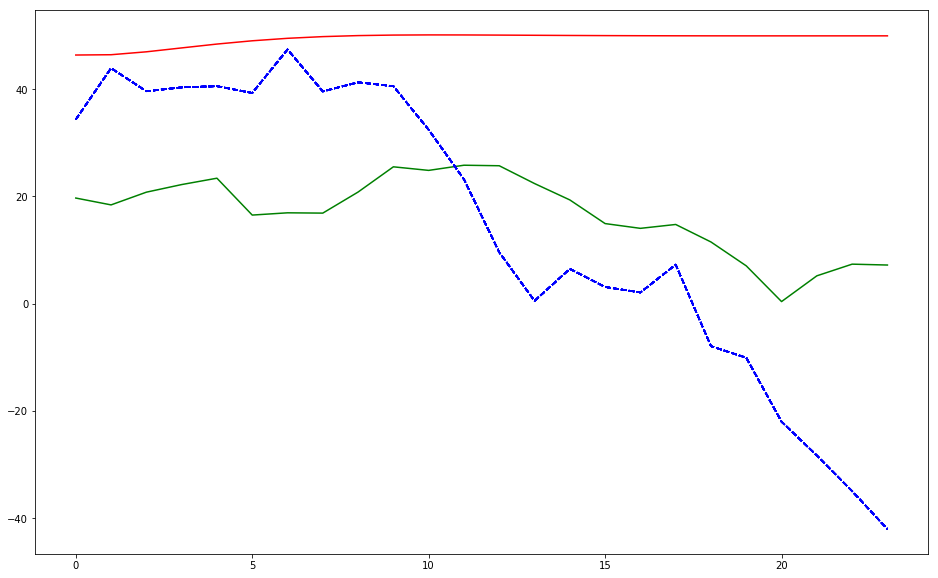

In [39]:
base = datetime.datetime(2016, 1, 1)
battery_pred = np.zeros(24)
lag = 24
for day in [base + datetime.timedelta(days=x) for x in range(0, 10)]:
    next_day =  day+datetime.timedelta(days=1)
    
    X_solar = np.array(pd.concat([weather_m[(weather_m.index >= day) & (weather_m.index < next_day)][['global_rad']],
                            weather_b[(weather_b.index >= day) & (weather_b.index < next_day)][['global_rad']],
                            weather_d[(weather_d.index >= day) & (weather_d.index < next_day)][['global_rad']]
                           ], axis=1)
                )
    
    X_wind = np.array(pd.concat([weather_m[(weather_m.index >= day) & (weather_m.index < next_day)][['wind_speed_10m']],
                            weather_b[(weather_b.index >= day) & (weather_b.index < next_day)][['wind_speed_10m']],
                            weather_d[(weather_d.index >= day) & (weather_d.index < next_day)][['wind_speed_10m']]
                           ], axis=1)
                )
    
    
    solar = np.array(energy[(energy.index >= day) & (energy.index < next_day)]['solarprod'])
    wind =  np.array(energy[(energy.index >= day) & (energy.index < next_day)]['windprod'])
    production = solar + wind
    consumption =  np.array(energy[(energy.index >= day) & (energy.index < next_day)]['consumption'])
    model = ARIMA(consumption, order=(2, 0, 1))
    ARIMA_fitted = model.fit(disp=-1)
    start_idx = consumption.shape[0]
    end_idx = start_idx + lag - 1
    
    wind_pred = pred_wind.predict(X_wind)
    solar_pred = pred_sun.predict(X_solar)
    production_pred = solar_pred + wind_pred
    consumption_pred = ARIMA_fitted.predict(start=start_idx, end=end_idx).reshape(-1, 1)
    
    #battery = minimize(cost_function, [production_pred, consumption_pred, battery_pred], method='nelder-mead')
    battery = production_pred - consumption_pred - battery_pred
    battery_pred = battery
    

plt.figure(figsize=(16,10))
plt.plot(production_pred, color='green', label='pred_production')
plt.plot(consumption_pred, color='red', label='pred_consumption')
plt.plot(battery_pred, color='blue', label='battery', linestyle='--')